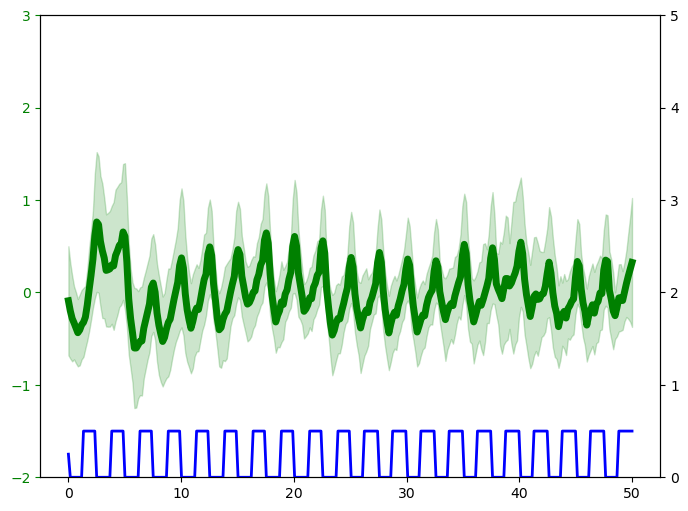

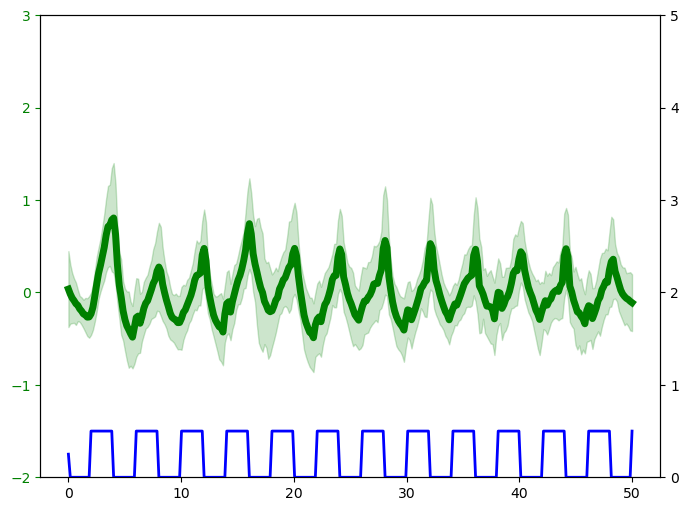

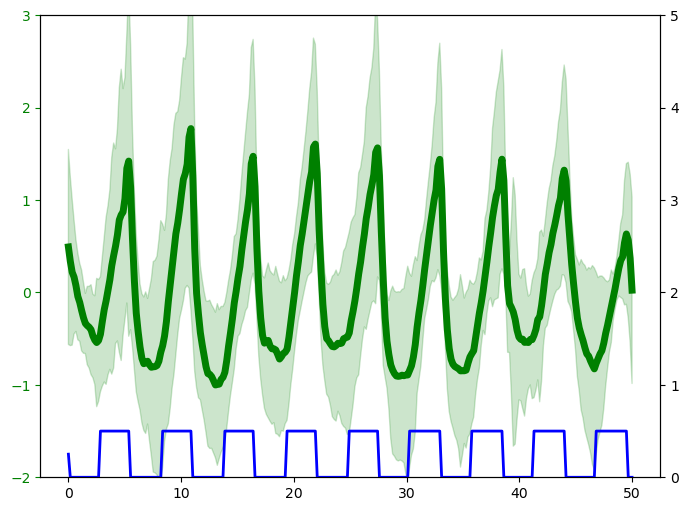

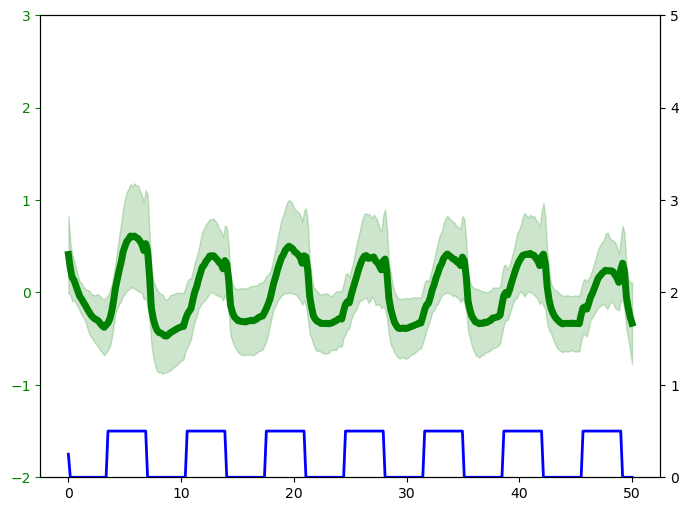

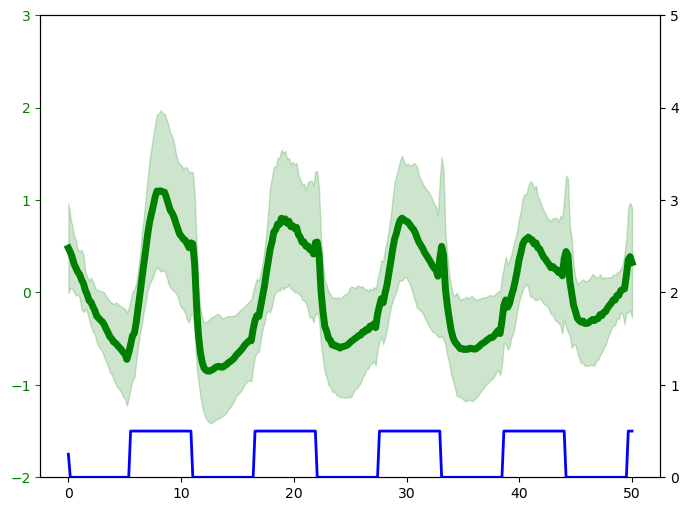

Bin width: 0.3999999999999999


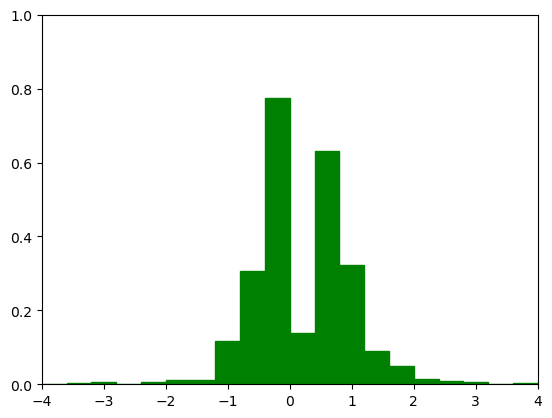

0.6762115092926089 -0.5927200517754547 1.2689315610680636


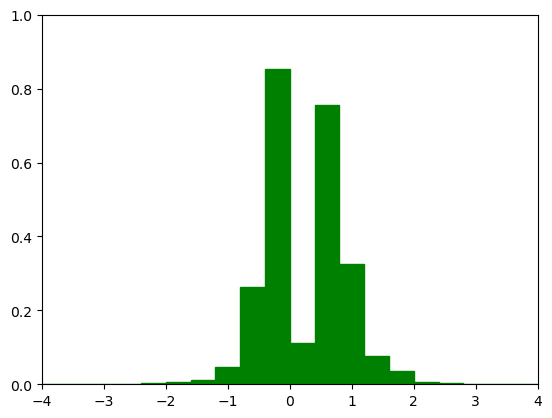

0.5715288452202579 -0.5173194076566899 1.0888482528769479


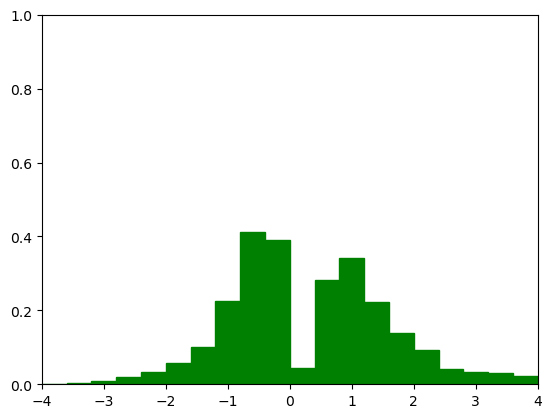

1.2129818618803667 -1.012163645974762 2.225145507855129


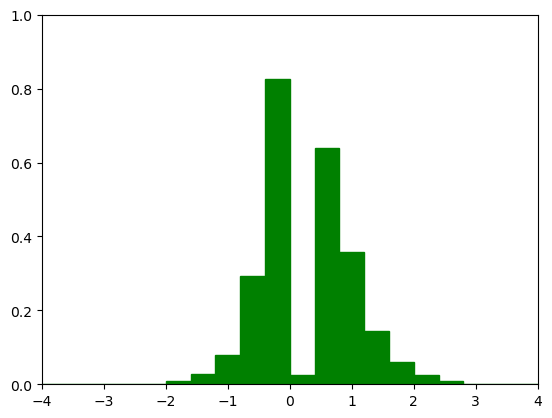

0.7106530899559127 -0.5733603766863288 1.2840134666422416


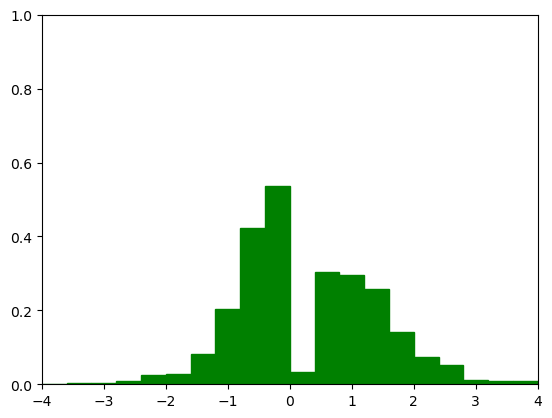

1.119020101363047 -0.8230127176069744 1.9420328189700213


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

def find_peaks_and_valleys(data, smooth_window=11, polyorder=2, prominence=1):
    """
    Find peaks and valleys in a noisy oscillatory dataset.
    
    Parameters:
    - data: The noisy input data (1D array).
    - smooth_window: Window length for the Savitzky-Golay filter (default: 11).
    - polyorder: The polynomial order for the Savitzky-Golay filter (default: 2).
    - prominence: Minimum prominence of peaks/valleys to detect (default: 1).
    
    Returns:
    - peaks: Indices of peaks (local maxima).
    - valleys: Indices of valleys (local minima).
    - smoothed_data: The filtered version of the input.
    """
    smoothed_data = savgol_filter(data, smooth_window, polyorder)
    peaks, _ = find_peaks(smoothed_data, prominence=prominence)
    valleys, _ = find_peaks(-smoothed_data, prominence=prominence)
    return peaks, valleys, smoothed_data


# Example noisy oscillatory data
np.random.seed(42)
t = np.linspace(0, 20, 100)
data = np.sin(t)
peaks, valleys, smoothed_data = find_peaks_and_valleys(
    data, smooth_window=21, polyorder=3, prominence=0.5
)


Names = ['2_5h_AllCells.txt', '4h_AllCells.txt', '5_5h_AllCells.txt',
         '7h_AllCells.txt', '11h_AllCells.txt']
TS = [2.5, 4, 5.5, 7, 11]

fs = 1.0/6
npx = 6

Data_As = []
EXT = []
test = -1
for iname, fname in enumerate(Names):
    DD = np.loadtxt(fname)
    as_tmp = []
    etr_tmp = []
    x_all = []
    test += 1
    for icell in range(DD.shape[0]):
        x = DD[icell, :]
        x = x/np.mean(x[:3])
        x = savgol_filter(x, 5, 2)
        #x = x[20:]
        
        t = np.linspace(0, len(x)/fs, len(x))
        fx = np.polyfit(t, x, npx)
        fy = np.polyval(fx, t)
        x -= fy
        
        # Fourier spectrum
        nf = len(x)
        Y = np.fft.fft(x)/nf
        Y = np.abs(Y[:nf//2])
        FFT_Ratio = np.max(Y)/np.mean(Y)
        as_tmp.append(FFT_Ratio)
        
        if FFT_Ratio > 6: ### Sorting out non-responsive cells
            peaks, valleys, smoothed_data = find_peaks_and_valleys(
                x, smooth_window=21, polyorder=3, prominence=0.5
            )
            x_all.append(x[:300])
            rpeaks = smoothed_data[peaks]
            rvalleys = smoothed_data[valleys]
            for ipeaks in rpeaks:
                etr_tmp.append(np.min([4, ipeaks]))
            for ivalleys in rvalleys:
                etr_tmp.append(np.max([-4, ivalleys]))

    Data_As.append(as_tmp)
    EXT.append(etr_tmp)
    x_all = np.array(x_all)
    y = np.mean(x_all,axis=0)
    ys = np.std(x_all,axis=0)
    t = np.linspace(0, len(y)*fs, len(y))
    # Plot the mean curve
     # Plotting data on the first y-axis
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(t,y, 'g-',lw=5)
    ax1.fill_between(t, y - ys, y + ys, color='g', alpha=0.2)
    ax1.tick_params('y', colors='g')
    ax1.set_ylim(-2, 3)
    # Create the second y-axis
    ax2 = ax1.twinx()
    # Plotting data on the second y-axis
    t = np.linspace(0,50,len(y));
    nutlin = 0.25*(1+np.sign(-np.sin(2*np.pi/TS[test]*t)))
    ax2.plot(t,nutlin, 'b-',lw = 2)
    ax2.set_ylim(0, 5)
    plt.show()
    

# Histograms
NX = 20
ix = np.linspace(-3.8, 3.8, NX)
wid = ix[1] - ix[0]

print("Bin width:", wid)
for i in range(5):
    H1 = np.zeros(NX)
    data = np.array(EXT[i])
    for lix in range(1, NX):
        H1[lix] = np.sum((data < ix[lix]) & (data >= ix[lix-1]))
    H1 /= (np.sum(H1) * wid)
    
    plt.bar(ix, H1, width=wid, color='green', edgecolor='green')
    plt.axis([-4, 4, 0, 1])
    plt.show()
    
    idPos = np.where(data > 0)
    idNeg = np.where(data <= 0)
    print(np.mean(data[idPos]), np.mean(data[idNeg]),
          np.mean(data[idPos]) - np.mean(data[idNeg]))



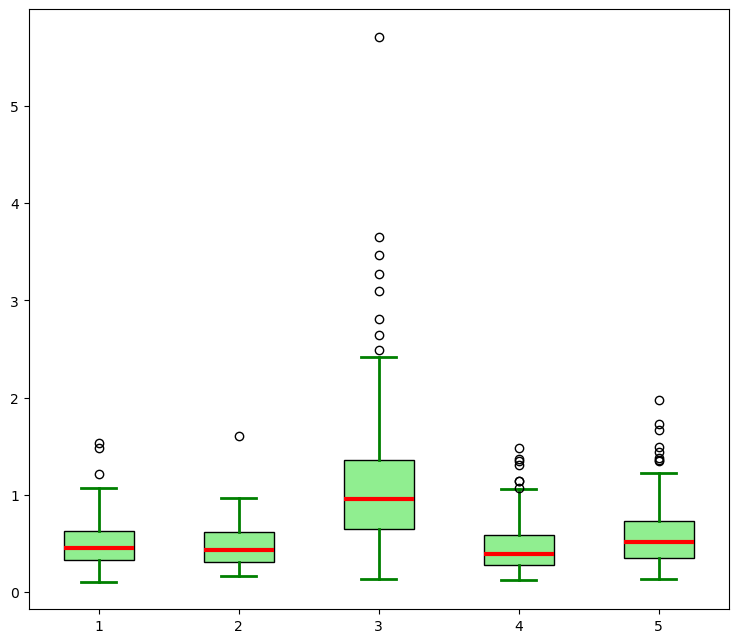

In [30]:
def findPeaks(x,n,tops,valleys):
    for i in range(n,len(x)-n):
        ct = 0; cb = 0
        for j in range(-n,n+1):           
            if (x[i]>x[i+j]):
                ct += 1
            if (x[i]<x[i+j]):
                cb += 1
       
        if ct == 2*n:
            tops.append(x[i])
        elif cb == 2*n:
            valleys.append(x[i])
    return tops,valleys   
TS = [2.5,4,5.5,7,10]
Data_All = []
stds = []
AMS = []
AMS0 = []
AllTopBot = []
n = 5
npx = 5
ci = 0
taus = [2,3,7,7,11]
Data_AMS = []
Data_21 = []
for iname in range(len(Names)):     
    ci += 1
    DD = np.loadtxt(Names[iname])
    XX = []
    T = TS[iname]
    NC,LC = np.shape(DD)
    AM = []
    AMAll = []
    TopBot = []
    AM0 = []
    a_21 = []
    cm = 0
    for icell in range(NC):
        tops = []
        valleys = []
        x = DD[icell,:]
        t = np.linspace(0,len(x)*1./6,len(x));
        x = x/np.mean(x[:3]);
        x = savgol_filter(x, 5, 2)
        t = np.linspace(0,len(x)*1./6,len(x));
        fx = np.polyfit(t,x,npx)
        fy = 0
        for i in range(len(fx)):
            fy += fx[i]*t**(npx-i)
        x -= fy
        x = x[20:]
        if (np.log(np.std(x))<-2 or len(np.argwhere(np.isnan(x)))>0):
            m = 0
            cm += 1
        else:
            m = 1
            tops,valleys = findPeaks(x,n,tops,valleys)
            for itop in tops:
                TopBot.append(itop)
            for itop in valleys:
                TopBot.append(itop)
            AM.append(0.5*(np.mean(tops)-np.mean(valleys)))
            AM0.append(0.5*((tops[0])-(valleys[1])))
            XX.append(x)
            
            peaks, properties = find_peaks(x, prominence=0.2) # Adjust the prominence value as needed
            peak_heights = x[peaks]
            for ipp in peak_heights:
                AMAll.append(ipp)
    mx = np.mean(XX,axis=0)

    AllTopBot.append(TopBot)
    t = np.linspace(0,0+(len(mx)-1)*1/6,len(mx))
    Data_AMS.append(AM)
    
    Data_All.append(AMAll)
    tau = taus[ci-1]
    
    
    AMS0.append([np.mean(AM0),np.std(AM0),len(AM0)])
    AMS.append([np.mean(AM),np.std(AM),len(AM)])


AMS = np.array(AMS)
AMS0 = np.array(AMS0)


fig = plt.figure(figsize =(7, 6))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
bp = ax.boxplot(Data_AMS,patch_artist=True,
                boxprops = dict(facecolor = "lightgreen"),
                whiskerprops = dict(color = "green", linewidth = 2),
               medianprops = dict(color = "red", linewidth = 3),
               capprops = dict(color = "green", linewidth = 2))
plt.show()
